In [1]:
# Imports
import torch
import torchvision
from torchvision.datasets import MNIST

In [2]:
# Download training dataset
dataset = MNIST(root='data/', download=True)

In [3]:
len(dataset)


60000

In [4]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x124B66810>, 5)

In [5]:
import matplotlib.pyplot as plt
# Tells jupyter to plot graphs in notebook
%matplotlib inline

Label:  1


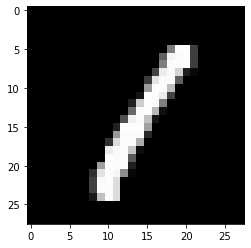

In [6]:
image, label = dataset[3]
plt.imshow(image, cmap='gray') # color map == grayscale image
print("Label: ", label)

In [7]:
# Need to convert these images into tensors
import torchvision.transforms as transforms

In [8]:
dataset = MNIST(root='data/',
               train=True,
               transform=transforms.ToTensor())

In [9]:
img_tensor, label = dataset[3]
print(img_tensor.shape, label)
# 1 dimensional image, 28 by 28. Would be 3 dimensions for RBG image
print(torch.max(img_tensor), torch.min(img_tensor))

torch.Size([1, 28, 28]) 1
tensor(1.) tensor(0.)


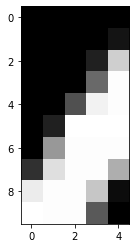

In [10]:
plt.imshow(img_tensor[0,10:20,10:15], cmap='gray')

In [11]:
"""
3 'Groups'
Training set - used to train the model i.e. compute the loss and adjust the weights of the model using gradient descent.
Validation set - used to evaluate the model while training, adjust hyperparameters (learning rate etc.) and pick the best version of the model.
Test set - used to compare different models, or different types of modeling approaches, and report the final accuracy of the model.

Additionally shuffle data so that the program recognises all numbers, rather than just 0-7.
Do not shuffle time data
"""

import numpy as np

def split_indices(n, val_pct):
    # determine size of validation set
    n_val = int(val_pct*n)
    # Create random permutation of 0 to n-1
    idxs = np.random.permutation(n)
    # Pick first n_val indices for validation set
    return idxs[n_val:], idxs[:n_val]
    



In [12]:
train_indices, val_indices = split_indices(len(dataset), val_pct=.2)

In [13]:
print(len(train_indices), len(val_indices))

48000 12000


In [14]:
print(val_indices[:20])

[30826 38754 21550 16814 30597 24014  2442 25154 57213 33540 16295 54063
 20632 50746 19131   335 15204 26352  2857 26077]


In [15]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [16]:
# Small batch size to limit number of calculations required
batch_size=100

# Training sampler and data loader 
train_sampler = SubsetRandomSampler(train_indices)
train_loader = DataLoader(dataset,
                         batch_size,
                         sampler=train_sampler)

# Validation sampler and data loader
val_sampler = SubsetRandomSampler(val_indices)
val_loader = DataLoader(dataset,
                       batch_size,
                       sampler=val_sampler)

In [17]:
# Can use nn.Linear, however we must convert each image into a vector so it can be used
# images are 28x28 so vector is 784. 
# Output will be a vector of size 10, each item will be probability of the model being that image

import torch.nn as nn

input_size = 28*28
num_classes = 10

# Log regression model
model = nn.Linear(input_size, num_classes)


In [18]:
print(model.weight.shape)
model.weight

torch.Size([10, 784])


Parameter containing:
tensor([[ 0.0345, -0.0097, -0.0099,  ..., -0.0207, -0.0301,  0.0327],
        [ 0.0153,  0.0324, -0.0313,  ..., -0.0109, -0.0235,  0.0235],
        [-0.0206, -0.0182,  0.0045,  ...,  0.0176,  0.0352, -0.0110],
        ...,
        [ 0.0163,  0.0181,  0.0329,  ...,  0.0060,  0.0355,  0.0182],
        [-0.0323,  0.0286,  0.0011,  ...,  0.0175,  0.0038,  0.0069],
        [-0.0171,  0.0226,  0.0235,  ...,  0.0350, -0.0276,  0.0256]],
       requires_grad=True)

In [19]:
print(model.bias.shape)
model.bias

torch.Size([10])


Parameter containing:
tensor([-0.0072,  0.0129, -0.0205,  0.0219, -0.0058, -0.0346,  0.0258, -0.0352,
         0.0178,  0.0138], requires_grad=True)

In [20]:
for images, labels in train_loader:
    print(labels)
    # the label is the correct number
    print(images.shape)
    outputs = model(images)
    break
    
# our images are in the wrong shape (look at size). Must flatten 1, 28, 28

tensor([2, 8, 3, 6, 8, 9, 5, 5, 5, 4, 1, 3, 0, 3, 4, 4, 7, 1, 9, 5, 7, 1, 4, 5,
        9, 2, 8, 7, 9, 0, 4, 3, 9, 2, 7, 2, 9, 5, 5, 1, 0, 2, 7, 2, 6, 8, 2, 4,
        4, 8, 1, 1, 8, 6, 1, 1, 1, 7, 1, 9, 5, 4, 1, 6, 4, 8, 5, 9, 7, 7, 2, 9,
        5, 7, 0, 0, 1, 1, 9, 0, 7, 0, 3, 8, 5, 3, 5, 6, 3, 0, 4, 5, 9, 2, 8, 6,
        1, 2, 9, 5])
torch.Size([100, 1, 28, 28])


RuntimeError: size mismatch, m1: [2800 x 28], m2: [784 x 10] at /tmp/pip-req-build-9oilk29k/aten/src/TH/generic/THTensorMath.cpp:197

In [21]:
# Extend nn.Module class from pytorch. Custom model

class MnistModel(nn.Module):
    def __init__(self):
        # super constructor for inheriting class
        super().__init__()
        # Model inside module, nested structure
        self.linear = nn.Linear(input_size, num_classes)
    # Must define forward method in any pytorch method
    def forward(self, xb):
        # remember -1 means choose what dimension should be
        # Allows model to stay generalized, i.e. batchsize can change
        xb = xb.reshape(-1, 784)
        # Pass reshaped matrix into linear model
        out = self.linear(xb)
        return out
    
model = MnistModel()
# Weight and bias inside model.linear now.

In [22]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.0326, -0.0038,  0.0332,  ..., -0.0114,  0.0008, -0.0156],
         [-0.0214,  0.0209,  0.0090,  ..., -0.0185,  0.0250,  0.0246],
         [ 0.0242, -0.0151,  0.0147,  ..., -0.0128,  0.0336,  0.0153],
         ...,
         [ 0.0234, -0.0328,  0.0245,  ...,  0.0243, -0.0167,  0.0180],
         [-0.0158,  0.0271, -0.0006,  ..., -0.0176,  0.0312, -0.0175],
         [ 0.0156,  0.0042,  0.0074,  ..., -0.0172, -0.0204, -0.0060]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0031, -0.0085, -0.0328,  0.0210,  0.0287,  0.0337,  0.0210,  0.0242,
         -0.0098,  0.0103], requires_grad=True)]

In [23]:
for images, labels in train_loader:
    outputs = model(images)
    break
    
print(outputs.shape) 
print(outputs[:2].data) # All these should be 0-1 and add up to 1 (not probabilities)

torch.Size([100, 10])
tensor([[ 0.3415, -0.0076, -0.5497,  0.2518,  0.3781,  0.0897,  0.1789, -0.1493,
          0.0113, -0.1751],
        [ 0.1232, -0.0383, -0.4656, -0.0722,  0.2571, -0.0189,  0.1212, -0.1224,
          0.0744, -0.2077]])


In [24]:
# Use softmax to convert Logits scores into probabilities if you want - easy implementation
# There is also a pyTorch method
import torch.nn.functional as F

In [25]:

probs = F.softmax(outputs, dim=1)

print("Probabilities: ", probs[:2].data)
# Sometimes there is floating point error with the sum. 
print("Sum of probabilites", torch.sum(probs[0].data))


Probabilities:  tensor([[0.1312, 0.0925, 0.0538, 0.1199, 0.1361, 0.1020, 0.1115, 0.0803, 0.0943,
         0.0783],
        [0.1151, 0.0979, 0.0639, 0.0947, 0.1316, 0.0998, 0.1148, 0.0900, 0.1096,
         0.0827]])
Sum of probabilites tensor(1.0000)


In [26]:
# Select the prediction based on the max probability element
max_probs, preds = torch.max(probs, dim=1)
print(preds)
# print(max_probs)

tensor([4, 4, 3, 0, 4, 3, 3, 4, 5, 0, 1, 0, 4, 6, 3, 0, 0, 9, 7, 0, 4, 4, 4, 3,
        5, 4, 4, 0, 3, 3, 4, 4, 3, 8, 0, 0, 4, 4, 5, 4, 4, 0, 3, 3, 4, 4, 4, 6,
        0, 4, 4, 3, 3, 5, 4, 3, 3, 1, 4, 0, 4, 6, 6, 4, 4, 7, 4, 3, 3, 4, 0, 3,
        4, 4, 3, 4, 0, 4, 4, 7, 0, 4, 9, 4, 0, 6, 4, 3, 4, 0, 4, 0, 3, 4, 3, 0,
        4, 3, 0, 4])


In [27]:
labels
# Model still poor, as no fine tuned weights or biases yet. Need to train model

tensor([9, 3, 5, 9, 5, 1, 2, 5, 6, 8, 7, 7, 5, 7, 8, 5, 4, 1, 7, 3, 8, 4, 6, 6,
        3, 0, 6, 1, 8, 3, 0, 7, 2, 3, 1, 1, 3, 4, 1, 0, 8, 9, 6, 8, 3, 8, 2, 4,
        1, 4, 5, 2, 2, 2, 9, 9, 3, 7, 8, 7, 3, 1, 5, 8, 8, 9, 0, 3, 1, 5, 2, 9,
        5, 0, 9, 5, 8, 0, 0, 4, 6, 3, 4, 5, 5, 7, 7, 1, 0, 0, 3, 7, 3, 0, 6, 8,
        8, 6, 8, 3])

In [28]:
# evaluation metrix and loss function
def accuracy(preds, labels):
    # This method uses the == method to return which predictions match up, 
    # and then divide it by length of the item to calculate % accuracy
    return torch.sum(preds==labels).item()/len(labels)



In [29]:
accuracy(preds, labels)

0.09

In [30]:
"""
torch.max and == are non-differentiable so cannot be used for predicting accuracy
Additionally, this doesn't analyze what the model 'thinks' of the correct label
probability. Feedback from loss function is not effective. Accuracy is good for 
final result evaluation, but not a good loss function.
"""

"\ntorch.max and == are non-differentiable so cannot be used for predicting accuracy\nAdditionally, this doesn't analyze what the model 'thinks' of the correct label\nprobability. Feedback from loss function is not effective. Accuracy is good for \nfinal result evaluation, but not a good loss function.\n"

In [31]:
# Cross entropy loss function is used. 
"""
When probability is low the (-) logarithm is higher, and vice versa.

"""

loss_fn = F.cross_entropy

In [32]:
# Loss for current batch of data
loss = loss_fn(outputs, labels)
print(loss)

tensor(2.3052, grad_fn=<NllLossBackward>)


In [33]:
#Optimiser 
learning_rate = .001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [34]:
def loss_batch(model, loss_func, xb, yb, opt=None, metric=None):
    # Calc loss
    preds = model(xb)
    loss = loss_func(preds, yb)
    
    if opt is not None:
        # compute gradients, update params, reset grads
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    metric_result = None
    if metric is not None:
        metric_result = metric(preds, yb)
    
    return loss.item(), len(xb), metric_result

In [35]:
def evaluate(model, loss_fn, valid_dl, metric=None):
    with torch.no_grad():
        results = [loss_batch(model, loss_fn, xb, yb, metric=metric)
                 for xb,yb in valid_dl]
        losses, nums, metrics = zip(*results)
        total = np.sum(nums)
        avg_loss = np.sum(np.multiply(losses, nums)/total)
        avg_metric = None
        if metric is not None:
            avg_metric = np.sum(np.multiply(metrics,nums)) / total
    return avg_loss, total, avg_metric

In [36]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds == labels).item() / len(preds)

In [37]:
val_loss, total, val_acc = evaluate(model, loss_fn, val_loader, metric=accuracy)
print(val_loss, val_acc)

2.322481228907903 0.1115


In [38]:
def fit(epochs, model, loss_fn, opt, train_dl, valid_dl, metric=None):
    for epoch in range(epochs):
        # Training
        for xb, yb in train_dl:
            loss,_,_ = loss_batch(model, loss_fn, xb, yb, opt)
        # Evaluation
        result = evaluate(model, loss_fn, valid_dl, metric)
        val_loss, total, val_metric = result
        
        #Print progress
        if metric is None:
            print('Epoch [{}/{}], Loss: {:.4f}'
                 .format(epoch+1, epochs, val_loss))
        else:
            print('Epoch [{}/{}], Loss: {:.4f}, {}: {:.4f}'
                 .format(epoch+1, epochs, val_loss, metric.__name__, val_metric))
        




In [39]:
model = MnistModel()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [40]:
fit(5, model, F.cross_entropy, optimizer, train_loader, val_loader, accuracy)

Epoch [1/5], Loss: 1.8942, accuracy: 0.6466
Epoch [2/5], Loss: 1.5920, accuracy: 0.7375
Epoch [3/5], Loss: 1.3795, accuracy: 0.7705
Epoch [4/5], Loss: 1.2270, accuracy: 0.7881
Epoch [5/5], Loss: 1.1139, accuracy: 0.8008


In [41]:
# Accuracy quickly jumps to 85% roughly but does not exceed 90%
"""
It is possible the learning rate isnt is too high, or more epochs are neccessary,
however it is most likely that the model isn't powerful enough. 

There is probably not a linear relationship between pixel intensity and the
labelled number. 
"""



"\nIt is possible the learning rate isnt is too high, or more epochs are neccessary,\nhowever it is most likely that the model isn't powerful enough. \n\nThere is probably not a linear relationship between pixel intensity and the\nlabelled number. \n"

In [42]:
# test with individual image

test_dataset = MNIST(root='data/',
                    train=False,
                    transform=transforms.ToTensor())


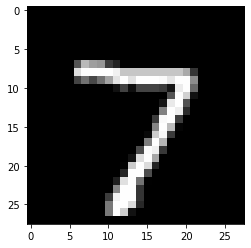

In [43]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')

In [44]:
img.unsqueeze(0).shape # prints unsqueezed shape

torch.Size([1, 1, 28, 28])

In [45]:
def predict_image(img, model):
    xb = img.unsqueeze(0) # becomes a 'batch' of one image
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()
    

Label:  3 , Predicted:  3


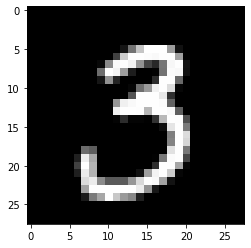

In [46]:
img, label = test_dataset[90]
plt.imshow(img[0], cmap='gray')
print('Label: ', label, ', Predicted: ', predict_image(img, model))

In [47]:
# Model cannot see a spatial relationship between pixels. Therefore is poor. 

In [48]:
# Model can be saved as

torch.save(model.state_dict(), 'mnist-logistic.pth')

In [49]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0055, -0.0139, -0.0163,  ...,  0.0026, -0.0009, -0.0057],
                      [ 0.0135,  0.0339, -0.0308,  ...,  0.0104, -0.0175,  0.0227],
                      [-0.0216, -0.0285,  0.0213,  ...,  0.0336,  0.0037, -0.0292],
                      ...,
                      [-0.0250, -0.0141,  0.0143,  ..., -0.0012,  0.0351, -0.0197],
                      [ 0.0142, -0.0028,  0.0174,  ...,  0.0037, -0.0256, -0.0284],
                      [-0.0184, -0.0129,  0.0293,  ..., -0.0061,  0.0033, -0.0147]])),
             ('linear.bias',
              tensor([-0.0279,  0.0573, -0.0257, -0.0231,  0.0087,  0.0371, -0.0351,  0.0426,
                      -0.0156, -0.0177]))])

In [50]:
model2 = MnistModel()
model2.load_state_dict(torch.load('mnist-logistic.pth'))
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0055, -0.0139, -0.0163,  ...,  0.0026, -0.0009, -0.0057],
                      [ 0.0135,  0.0339, -0.0308,  ...,  0.0104, -0.0175,  0.0227],
                      [-0.0216, -0.0285,  0.0213,  ...,  0.0336,  0.0037, -0.0292],
                      ...,
                      [-0.0250, -0.0141,  0.0143,  ..., -0.0012,  0.0351, -0.0197],
                      [ 0.0142, -0.0028,  0.0174,  ...,  0.0037, -0.0256, -0.0284],
                      [-0.0184, -0.0129,  0.0293,  ..., -0.0061,  0.0033, -0.0147]])),
             ('linear.bias',
              tensor([-0.0279,  0.0573, -0.0257, -0.0231,  0.0087,  0.0371, -0.0351,  0.0426,
                      -0.0156, -0.0177]))])